# Round Robin Data Set Tests

This notebook tests the histogram tools against the famous SAS "Round Robin" paper.  It's the best open source data that I've found so far, but it is a reduced data set in a histogrammed format.  Nonetheless, it makes a good test of some of the tools that are being worked on.

The article is here:
https://arxiv.org/pdf/2303.03772.pdf

The source data comes from here (but it's also in the repository, they are not big files):
https://zenodo.org/record/7506365

At first I was playing with the idea to sample the histograms to create an event array, but then I found that the data sets are exhibiting distributions of parameters rather than single parameter values.  I've made a histogram version of some of the event code for testing (bayesianInverse) and that will actually be used for most of this notebook as you will see.



## Sampling Histogram to Events

This might be useful at some point.  It assumes that the histogram bins are narrow.  Wide bins will create artefacts. 

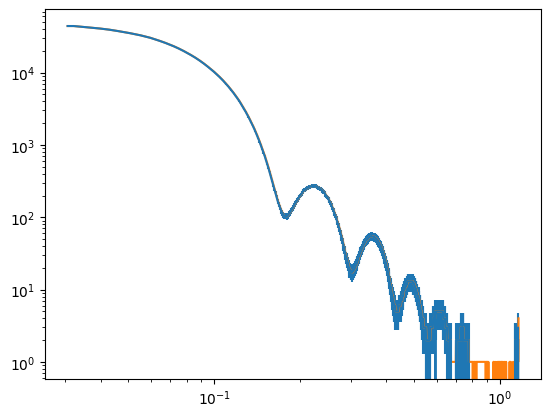

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# This first cell evaluates whether we can re-generate events from the histogram reliably.
# It is not used, you can skip it to the next bit which is more interseting...

# Bimodal gold contains 30 nm and 60 nm particles (300, 600 Å)
bmgold = np.loadtxt('data/roundrobin/dataset_2.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]

#mask = xdata < 1.0

#xdata = xdata[mask]
#ydata = ydata[mask]
#edata = edata[mask]

def rescale(yvals, evals):
    # Rescales yvals and errors data so that the error bars correctly match integer 
    # counts listed in yvals
    
    ymin = np.amin(yvals)
    ysum = np.sum(yvals)
    esum = np.sum(evals)
    rt = np.sqrt(ysum)
    
    factr = esum / rt
    factr = factr ** 2.0
    
    yvals = yvals * factr
    #esum = esum * factr
    
    #yvals = np.round(yvals).astype(int)
    
    return (yvals) 
    
def resample(xvals, yvals):
    # Resamples a histogram

    xpt = xvals[0]
    count = yvals[0]
    events = np.full((count), xpt)
    
    for bin in range(1, xvals.size, 1):
        xpt = xvals[bin]
        count = yvals[bin]
        
        if count > 1:
            evs = np.full((count), xpt)
            events = np.concatenate((events, evs))
    np.random.shuffle(events)
    return events


#ydata = rescale(ydata, edata)
ydata = ydata.astype(int)
events = resample(xdata, ydata)

nbins = xdata.size

lw = np.amin(events)
hi = np.amax(events)

#print(lw, hi)

slic = (hi-lw)/(nbins+1)

hbins = np.arange(lw, hi, slic)

hst = np.histogram(events, bins=hbins)
yhst = hst[0]
err = np.sqrt(yhst)
xhst = np.delete(hbins,-1)

#print(yhst)
#print(ydata)
fig,ax=plt.subplots()
ax.errorbar(xhst, yhst, err)
ax.plot(xdata, ydata)
ax.set_xscale('log')
ax.set_yscale('log')


## Try Bayesian Inference on the sample with the narrowest distribution

array([22.])

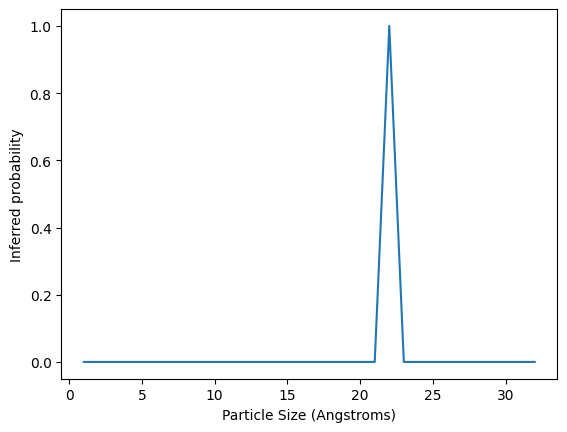

In [5]:
import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

# Bimodal gold contains 30 nm and 60 nm particles (300, 600 Å)
bmgold = np.loadtxt('data/roundrobin/dataset_2.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]

#mask = xdata < 1.0

#xdata = xdata[mask]
#ydata = ydata[mask]
#edata = edata[mask]

model = bayesianInverse.bayesianSpheres()

model.datax = np.array(xdata)
model.datay = np.array(ydata)

model.infer(plotr=True)

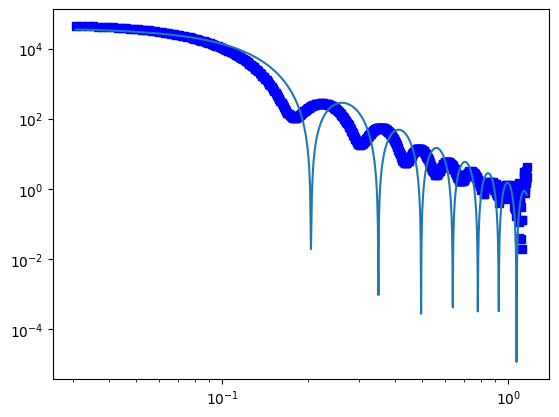

In [3]:
model.plotfit()

It's not a narrow distribution, it's quite wide, so even that data set requires deconvolution.

## Lucy Richardson Deconvolution (All 4 Data Sets)

Sample dataset number 1 contains contains 30 nm and 60 nm diameter particles.  They are in a number ratio of 1:1, which means that they are in a volume ratio of 1:8 respectively.

In [37]:
import matplotlib.pyplot as plt1
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

bmgold = np.loadtxt('data/roundrobin/dataset_1.dat')


xdata = bmgold[:,0]
ydata = bmgold[:,1]
edata = bmgold[:,2]



model = bayesianInverse.bayesianSpheres()

model.datax = np.array(xdata)
model.datay = np.array(ydata)
model.sigmay= np.array(edata)

resto, errors = model.LR_deconv(niter=3000, calcErrors=True)

Lucy-Richardson deconvolution is approaching convergence after 3000 iterations.
x2= 1.427547241606825


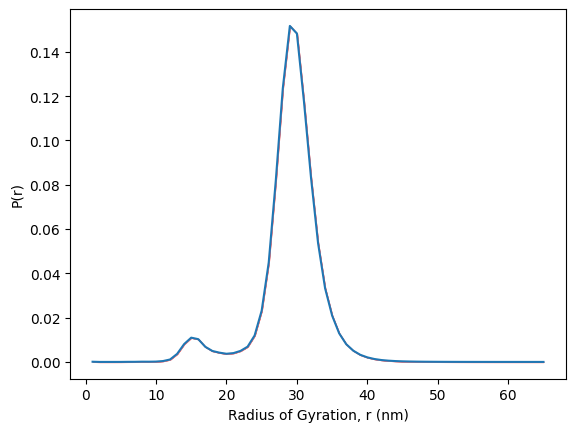

In [38]:
fity = model.getfity(resto, model.psf)

dats = np.sum(ydata)
fits = np.sum(fity)
fity = fity * dats/fits

psf, rvals = model.calc_psf()

top = resto+errors

bot = np.maximum(resto-errors, np.zeros_like(resto))

fig, ax = plt.subplots()
ax.plot(rvals, resto)

ax.fill_between(rvals, top, bot, color='red', alpha=0.5)

ax.set_xlabel("Radius of Gyration, r (nm)")
ax.set_ylabel("P(r)")
plt.show()

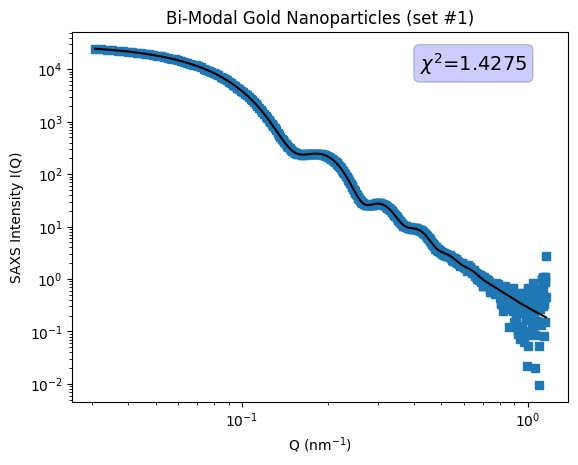

In [36]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 's')
ax.plot(xdata, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Q (nm$^{-1}$)")
ax.set_ylabel("SAXS Intensity I(Q)")
ax.set_title('Bi-Modal Gold Nanoparticles (set #1)')

chisq = model.x2(ydata, fity, edata)

insetstr = ''.join((r'$\chi ^{2}$=%.4f' % (chisq)))#/ydata.size)))
decs = dict(boxstyle='round', facecolor='blue', alpha=0.2)
ax.text(0.7, 0.95, insetstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=decs)
plt.show() # this just gets rid of the return value of the last matplotlib command

Sample dataset number 2 are from silica spheres with a nominal diameter of 60 nm.  The other analyses found that it was closer to 50 nm diameter with their fits.  There is a slight distribution on the size curve, which is why the bayesian inference fails in the intro section at the top of the page.

In [91]:
# Lucy Richardson
# Data Set #2
import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

silica = np.loadtxt('data/roundrobin/dataset_2.dat')


xdata = silica[:,0]
ydata = silica[:,1]
edata = silica[:,2]



model = bayesianInverse.bayesianSpheres()

model.datax = np.array(xdata)
model.datay = np.array(ydata)
model.sigmay= np.array(edata)

resto, errors = model.LR_deconv(niter=3000, calcErrors=True)

Lucy-Richardson fit failed to converge after 3000 iterations.
x2= 71.97964519830245


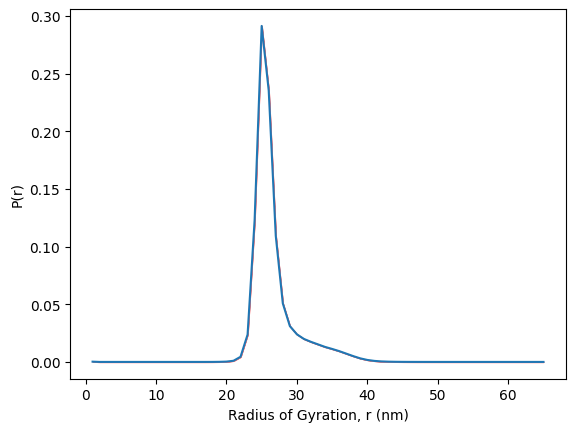

In [40]:
fity = model.getfity(resto, model.psf)

dats = np.sum(ydata)
fits = np.sum(fity)
fity = fity * dats/fits

psf, rvals = model.calc_psf()

top = resto+errors

bot = np.maximum(resto-errors, np.zeros_like(resto))

fig, ax = plt.subplots()
ax.plot(rvals, resto)

ax.fill_between(rvals, top, bot, color='red', alpha=0.5)

ax.set_xlabel("Radius of Gyration, r (nm)")
ax.set_ylabel("P(r)")
plt.show()

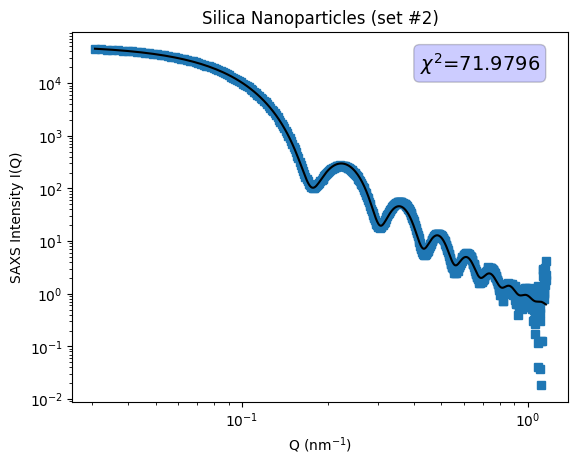

In [41]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 's')
ax.plot(xdata, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Q (nm$^{-1}$)")
ax.set_ylabel("SAXS Intensity I(Q)")
ax.set_title('Silica Nanoparticles (set #2)')

chisq = model.x2(ydata, fity, edata)

insetstr = ''.join((r'$\chi ^{2}$=%.4f' % (chisq)))#/ydata.size)))
decs = dict(boxstyle='round', facecolor='blue', alpha=0.2)
ax.text(0.7, 0.95, insetstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=decs)
plt.show()

Dataset number 3 is tricky.  These are 22 nm silica spheres mixed 1:1 by mass with some other particle size.  The fits from other scientists indicate 29 nm and 215 nm are obtained.  For this, I played with forcing the R range limits and cutting the Q range of the data ensure it was in the SAS regime.

Spheres is not a good model for this data.  They are too "blobby" for spheres.  Also, there is an up-turn at low-Q which was not discussed in the paper but which indicates some larger objects in the mix.  This could be a background effect from some other part of the experiment, but it's in the data so I'm going to fit it.

In [126]:
# Lucy Richardson
# Data Set #3
import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

histos = np.loadtxt('data/roundrobin/dataset_3.dat')


xdata = histos[:,0]
ydata = histos[:,1]
edata = histos[:,2]

mask = xdata < 2.0

xdata = xdata[mask]
ydata = ydata[mask]
edata = edata[mask]


model = bayesianInverse.bayesianSpheres()
rlimits = np.array([1, 250.0, 0.5])
model.setRlimits(rlimits)

model.datax = np.array(xdata)
model.datay = np.array(ydata)
model.sigmay= np.array(edata)

resto, errors = model.LR_deconv(niter=3000, calcErrors=True)

Lucy-Richardson fit failed to converge after 3000 iterations.
x2= 473.0535440772241


Text(0, 0.5, 'P(r)')

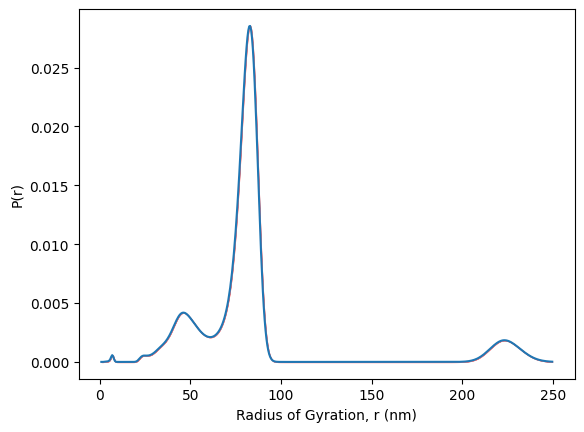

In [127]:
fity = model.getfity(resto, model.psf)

dats = np.sum(ydata)
fits = np.sum(fity)
fity = fity * dats/fits

psf, rvals = model.calc_psf()

top = resto+errors

bot = np.maximum(resto-errors, np.zeros_like(resto))

fig, ax = plt.subplots()
ax.plot(rvals, resto)

ax.fill_between(rvals, top, bot, color='red', alpha=0.5)

ax.set_xlabel("Radius of Gyration, r (nm)")
ax.set_ylabel("P(r)")

Text(0.7, 0.95, '$\\chi ^{2}$=473.0535')

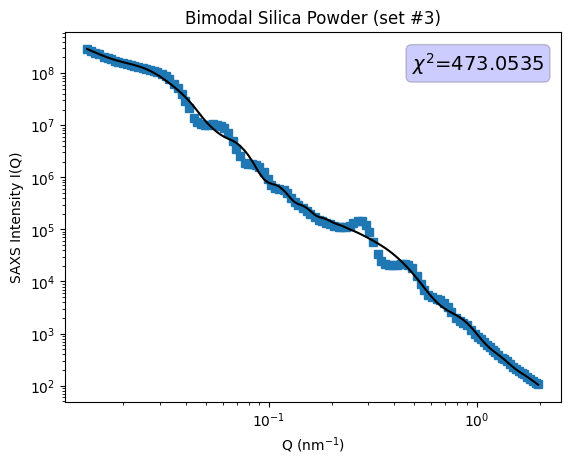

In [128]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 's')
ax.plot(xdata, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Q (nm$^{-1}$)")
ax.set_ylabel("SAXS Intensity I(Q)")
ax.set_title('Bimodal Silica Powder (set #3)')

chisq = model.x2(ydata, fity, edata)

insetstr = ''.join((r'$\chi ^{2}$=%.4f' % (chisq)))#/ydata.size)))
decs = dict(boxstyle='round', facecolor='blue', alpha=0.2)
ax.text(0.7, 0.95, insetstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=decs)

This final data set contains gold nanoparticles.  They are apparently a commercial supply from PlasmaChem GmbH in Berlin, catalogue number PL-D-G02.  The nominal size is 4-6 nm.  

In [164]:
# Lucy Richardson
# Data Set #4
import matplotlib.pyplot as plt
import bayesianInverse

from importlib import reload

reload(bayesianInverse)

diamonds = np.loadtxt('data/roundrobin/dataset_4.dat')


xdata = diamonds[:,0]
ydata = diamonds[:,1]
edata = diamonds[:,2]

mask = xdata < 2.0

xdata = xdata[mask]
ydata = ydata[mask]
edata = edata[mask]

model = bayesianInverse.bayesianSpheres()
rlimits = np.array([1, 450.0, 1.0])
model.setRlimits(rlimits)

model.datax = np.array(xdata)
model.datay = np.array(ydata)
model.sigmay= np.array(edata)

resto, errors = model.LR_deconv(niter=3000, calcErrors=True)

Lucy-Richardson deconvolution converged after 245 iterations.
x2= 0.9969486973520197


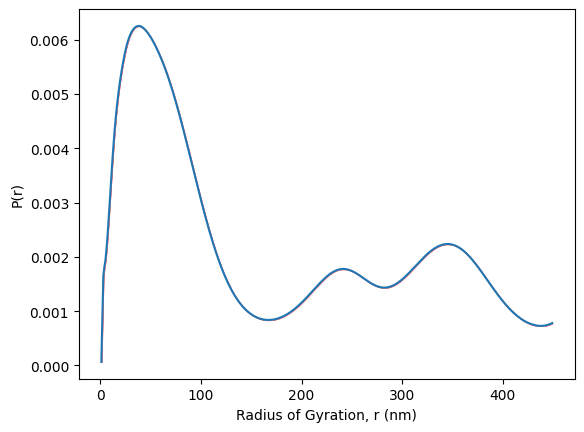

In [165]:
fity = model.getfity(resto, model.psf)

dats = np.sum(ydata)
fits = np.sum(fity)
fity = fity * dats/fits

psf, rvals = model.calc_psf()

top = resto+errors

bot = np.maximum(resto-errors, np.zeros_like(resto))

fig, ax = plt.subplots()
ax.plot(rvals, resto)

ax.fill_between(rvals, top, bot, color='red', alpha=0.5)

ax.set_xlabel("Radius of Gyration, r (nm)")
ax.set_ylabel("P(r)")
plt.show()

There seems to be a broad range of things in this data, but nothing sharp at all around 5 nm.  I actually have my doubts about diamond powders in general, due to the way they are made.  The moderator studies on these also indicate a much broader distribution than what is written on the tin!  Nonetheless, you can see in this data that there are a lot of background effects.

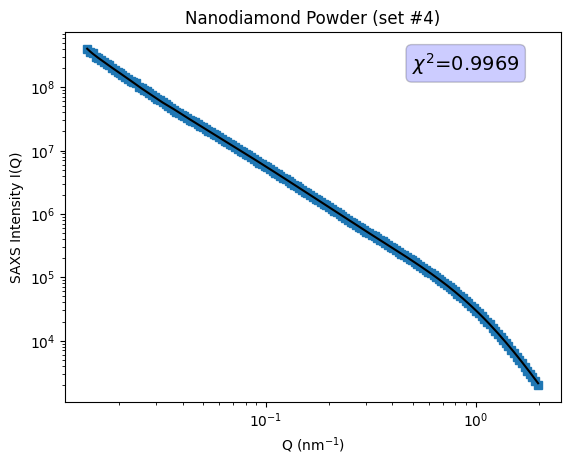

In [166]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 's')
ax.plot(xdata, fity, color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Q (nm$^{-1}$)")
ax.set_ylabel("SAXS Intensity I(Q)")
ax.set_title('Nanodiamond Powder (set #4)')

chisq = model.x2(ydata, fity, edata)

insetstr = ''.join((r'$\chi ^{2}$=%.4f' % (chisq)))#/ydata.size)))
decs = dict(boxstyle='round', facecolor='blue', alpha=0.2)
ax.text(0.7, 0.95, insetstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=decs)
plt.show()